In [25]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

train_df = pd.read_csv('train.csv') # 모두 정상 Sample
test_df = pd.read_csv('test.csv')

def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            for i in range(0, len(e), 30):
                y_feature.append(np.mean(e[i:i+30]))
        features.append(y_feature)
    return features

train_0 = train_df[train_df["FAN_TYPE"] == 0].reset_index(drop = True)
train_2 = train_df[train_df["FAN_TYPE"] == 2].reset_index(drop = True)

test_0 = test_df[test_df["FAN_TYPE"] == 0].reset_index(drop = True)
test_2 = test_df[test_df["FAN_TYPE"] == 2].reset_index(drop = True)

train_0_features = get_mfcc_feature(train_0)
train_2_features = get_mfcc_feature(train_2)
test_0_features = get_mfcc_feature(test_0)
test_2_features = get_mfcc_feature(test_2)

print(" train_0_features.shape:", len(train_0_features),
     "\n train_2_features.shape:", len(train_2_features),
     "\n test_0_features.shape:", len(test_0_features),
     "\n test_2_features.shape:", len(test_2_features))

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

 train_0_features.shape: 639 
 train_2_features.shape: 640 
 test_0_features.shape: 779 
 test_2_features.shape: 735


In [26]:
len(train_0_features[0])

1408

In [27]:
len(train_0_features)

639

In [44]:
len(test_df)

1514

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from tqdm.notebook import trange
from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
from sklearn.preprocessing import MinMaxScaler

def scaling(train_features, test_features):
    pre_train = np.array(train_features)
    pre_test = np.array(test_features)

    scaler = MinMaxScaler()

    scaler.fit(pre_train)

    train_data = scaler.transform(pre_train)
    test_data = scaler.transform(pre_test)

    count = 0

    for i in tqdm(range(len(train_data))):
        for j in range(len(train_data[i])):
            if train_data[i][j] > 1 or train_data[i][j] < -1:
                count += 1

    print()
    print("scaling이 잘못된 개수:",count)
    print()

    count = 0

    for i in tqdm(range(len(test_data))):
        for j in range(len(test_data[i])):
            if test_data[i][j] > 1 :
                test_data[i][j] = 1
                count += 1
            elif test_data[i][j] < 0:
                test_data[i][j] = 0
                count += 1
    print()
    print("고친 test set의 개수:",count)
    print()

    count = 0

    for i in range(len(test_data)):
        for j in range(len(test_data[i])):
            if test_data[i][j] > 1 or test_data[i][j] < -1:
                count += 1

    print(count)


    train_data = train_data.reshape(-1, 1, len(train_features[0]))
    test_data = test_data.reshape(-1, 1, len(train_features[0]))

    print()
    print("train_data의 shape:",train_data.shape)
    print()
    return train_data, test_data

In [30]:
train_0_data, test_0_data = scaling(train_0_features, test_0_features)
train_2_data, test_2_data = scaling(train_2_features, test_2_features)

  0%|          | 0/639 [00:00<?, ?it/s]


scaling이 잘못된 개수: 76



  0%|          | 0/779 [00:00<?, ?it/s]


고친 test set의 개수: 10960

0

train_data의 shape: (639, 1, 1408)



  0%|          | 0/640 [00:00<?, ?it/s]


scaling이 잘못된 개수: 61



  0%|          | 0/735 [00:00<?, ?it/s]


고친 test set의 개수: 37586

0

train_data의 shape: (640, 1, 1408)



In [31]:
########################### model 불러오기 #################################

def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=16, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            11534848  
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

Epoch 141/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 142/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0123
Epoch 143/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 144/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 145/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 146/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0123
Epoch 147/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 148/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 149/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 150/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0112

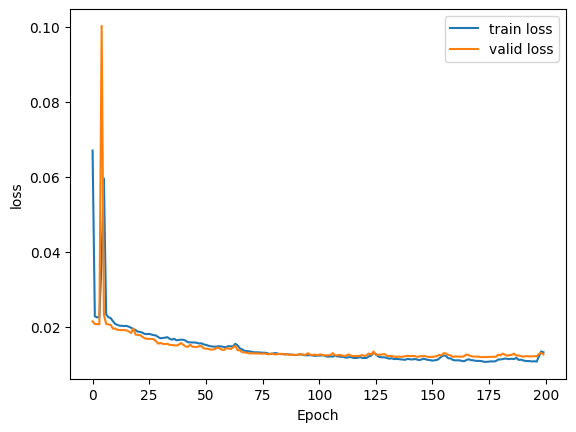

In [33]:
model = conv_auto_model(train_0_data)
model.compile(optimizer='adam', loss='mse')
model.summary()

epochs = 200
batch = 16

# fit
history = model.fit(train_0_data, train_0_data,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2).history

model.save('train_0_model.h5')

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            11534848  
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

Epoch 141/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0156
Epoch 142/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0140 - val_loss: 0.0154
Epoch 143/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0143 - val_loss: 0.0161
Epoch 144/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0144 - val_loss: 0.0159
Epoch 145/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 146/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0154
Epoch 147/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0141 - val_loss: 0.0157
Epoch 148/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 149/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0161
Epoch 150/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0148

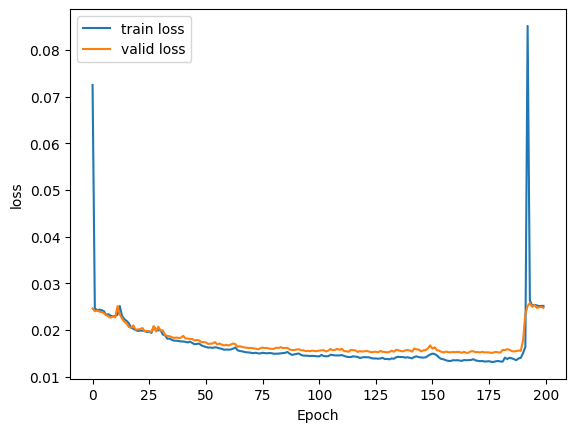

In [34]:
model = conv_auto_model(train_2_data)
model.compile(optimizer='adam', loss='mse')
model.summary()

epochs = 200
batch = 16

# fit
history = model.fit(train_2_data, train_2_data,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2).history

model.save('train_2_model.h5')

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [35]:
########################### model 불러오기 #################################


def pred_data(test_data, model):
    model = load_model(model)

    print()
    print("Model Load Complete")
    print()

    test_data_predictions = model.predict(test_data)

    print("예상 결과치의 shape: ",test_data_predictions.shape)

    test_data = test_data.reshape(-1,len(test_data[0]))
    test_data_predictions = test_data_predictions.reshape(-1,len(test_data[0]))

    count = 0

    for i in tqdm(range(len(test_data_predictions))):
        for j in range(len(test_data_predictions[i])):
            if test_data_predictions[i][j] > 1 :
                test_data_predictions[i][j] = 1
                count += 1
            elif test_data_predictions[i][j] < 0:
                test_data_predictions[i][j] = 0
                count += 1

    print()
    print("고쳐진 test_data_predictions 의 개수:", count)
    print()

    error = test_data- test_data_predictions

    valid_mse = np.mean(np.power(error, 2), axis=1)

    error_df = pd.DataFrame({'Reconstruction_error': valid_mse})

    error_df["True_class"] = 1

    precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])
    
    return error_df

In [36]:
error_0_df = pred_data(test_0_data, "train_0_model.h5")


Model Load Complete

25/25 [==============================] - 0s 4ms/step
예상 결과치의 shape:  (779, 1, 1408)


  0%|          | 0/1096832 [00:00<?, ?it/s]


고쳐진 test_data_predictions 의 개수: 1067



In [37]:
error_2_df = pred_data(test_2_data, "train_2_model.h5")


Model Load Complete

23/23 [==============================] - 0s 10ms/step
예상 결과치의 shape:  (735, 1, 1408)


  0%|          | 0/1034880 [00:00<?, ?it/s]


고쳐진 test_data_predictions 의 개수: 0



In [54]:
error_2_df

,Reconstruction_error,True_class
0,0.011922,1
1,0.006949,1
2,0.003623,1
3,0.002749,1
4,0.003631,1
...,...,...
1034875,0.128360,1
1034876,0.129595,1
1034877,0.134039,1
1034878,0.082905,1


In [55]:
error_0_df

,Reconstruction_error,True_class
0,0.032462,1
1,0.029462,1
2,0.015788,1
3,0.051862,1
4,0.013916,1
...,...,...
1096827,0.011360,1
1096828,0.007516,1
1096829,0.057981,1
1096830,0.004543,1


In [59]:
max_standard2 = np.percentile(error_2_df["Reconstruction_error"], 38)

max_standard2


0.008963023647665977

In [52]:

def make_pred(error_0_df, standard_0):
    pred_part1 = []
    max_standard0 = np.percentile(error_0_df["Reconstruction_error"], standard_0)

    for k in error_0_df["Reconstruction_error"]:
        if k < max_standard0:
            pred_part1.append(0)
        else:
            pred_part1.append(1)
            
    return np.array(pred_part1)
    
def make_csv(pred_part1, pred_part2, test_df):
    pred = []
    count_0 = 0
    count_2 = 0

    for i in range(len(test_df)):
        if test_df["FAN_TYPE"][i] == 0:
            pred.append(pred_part1[count_0])
            count_0 += 1
        elif test_df["FAN_TYPE"][i] == 2:
            pred.append(pred_part2[count_2])
            count_2 += 1 

    counts = 0
    for i in pred:
        if i == 1:
            counts += 1
    print("불량의 개수:", counts)
    
    return np.array(pred)

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

# FANTYPE 2는 고정한 채 FANTYPE 0를 변경
# FANTYPE 0 Max_Standard = 35

In [63]:

pred_part1 = make_pred(error_0_df,45)
pred_part2 = make_pred(error_2_df,52)

pred = make_csv(pred_part1, pred_part2, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_45_52_new.csv",index=False)

불량의 개수: 849


# FANTYPE 0 Max_Standard = 40

In [15]:
pred = make_csv(error_0_df, error_2_df, 40, 0, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_0_0-40.csv",index=False)

불량의 개수: 1275


# FANTYPE 0 Max_Standard = 45

In [16]:
pred = make_csv(error_0_df, error_2_df, 45, 0, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_0_45.csv",index=False)

불량의 개수: 1235


# FANTYPE 0 Max_Standard = 50

In [17]:
pred = make_csv(error_0_df, error_2_df, 50, 0, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_0_50.csv",index=False)

불량의 개수: 1193


# FANTYPE 0 Max_Standard = 55

In [18]:
pred = make_csv(error_0_df, error_2_df, 55, 0, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_0_55.csv",index=False)

불량의 개수: 1150


# FANTYPE 2 Max_Standard = 35

In [19]:
pred = make_csv(error_0_df, error_2_df, 0, 35, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_2_35.csv",index=False)

불량의 개수: 1171


# FANTYPE 2 Max_Standard = 40

In [20]:
pred = make_csv(error_0_df, error_2_df, 0, 40, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_2_40.csv",index=False)

불량의 개수: 1132


# FANTYPE 2 Max_Standard = 45

In [21]:
pred = make_csv(error_0_df, error_2_df, 0, 45, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_2_45.csv",index=False)

불량의 개수: 1087


# FANTYPE 2 Max_Standard = 50

In [22]:
pred = make_csv(error_0_df, error_2_df, 0, 50, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_2_50.csv",index=False)

불량의 개수: 1043


# FANTYPE 2 Max_Standard = 55

In [23]:
pred = make_csv(error_0_df, error_2_df, 0, 55, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_2_55.csv",index=False)

불량의 개수: 1005


# FANTYPE 0: 55
# FANTYPE 2: 55

In [13]:
pred = make_csv(error_0_df, error_2_df, 55, 55, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_55-55.csv",index=False)

불량의 개수: 634


In [14]:
pred = make_csv(error_0_df, error_2_df, 40, 40, test_df)

submit = pd.read_csv('sample_submission.csv')
submit['LABEL'] = pred
submit.to_csv("FANTYPE_40-40.csv",index=False)

불량의 개수: 877
